In [1]:
    from IPython.core.display import HTML
    
    def css_styling():
        styles = open("custom.css", "r").read()
        return HTML(styles)
    css_styling()


# Biophysical parameter retrieval with ``eoldas_ng``

#### J Gómez-Dans (NCEO & UCL)



## Introduction

In this practical, we consider the problem of extracting meaningful biophysical parameters from optical Earth Observation (EO) data. More concretely, we will use **bihemispherical broadband albedoes** as our input, interpret them through a simple **two-stream radiative transfer scheme** in order to retrieve a handful of parameters which are of interest in a large number of applications:

1. Parameters related to leaf reflectance and transmittance in the visible and near-infrarred regions of the spectrum,
2. Parameters describing the albedo of the soil under the vegetation,
3. The *amount of vegetation*, expressed through an *effective* leaf area index (LAI).

The two stream model has been used both for parameter retrieval (as we shall do here), but has also been implemented in a number of dynamic global vegetation models (DGVMs). This means that the parameters that are retrieved here will be strictly compatible with the same concepts in the DGVM, making them directly useable.

In this practical, we consider that the main role of the vegetation is in **flux partitioning**, or in other words,the amount of radiation that is absorbed by the canopy to be further used in photosynthesis, for example. 

## Bits 'n' bobs

### The input data

A number of albedo products exist, such as the [GlobAlbedo product](http://globalbedo.org) or the [MODIS albedo product](https://www.umb.edu/spectralmass/terra_aqua_modis/v006/mcd43a2_albedo_product). In either of these cases, the products produce an estimate of the **bi-hemispherical reflectance** (BHR) (or *white sky albedo*) for a particular area at a particular time. The differences in these prodcuts are to do with whether data from one particular sensor was used, but are broadly comparable.

We have extracted some data from the MODIS Collection 5 albedo product over a number of [FLUXNET sites](http:/fluxnet.ornl.gov/). These are:

| Site code | Site Name |
|-----------|-----------|
|AU-Tum | Tumbarumba|
|BR-Cax | Caxiuana Forest-Almeirim|
|CA-Ca1 | BC-Campbell River 1949 Douglas-fir|
|DE-Geb | Gebesee|
|DE-Hai | Hainich|
|ES-LMa | Las Majadas del Tietar|
|FI-Hyy | Hyytiala|
|FR-Lam | Lamasquere|
|IT-SRo | San Rossore|
|RU-Ylr | Yakutsk-Larch|
|SE-Abi | Abisko|
|US-Bar | Bartlett Experimental Forest|
|US-Bo1 | Bondville|
|US-Brw | Barrow |
|US-Dk2 | Duke Forest Hardwoods|
|US-Ha2 | Harvard Forest Hemlock Site|
|US-MMS | Morgan Monroe State Forest|
|US-Me2 | Metolius Intermediate Pine|
|US-Me3 | Metolius Second Young Pine|
|US-Ne1 | Mead - irrigated continuous maize site|
|US-Ne2 | Mead - irrigated maize-soybean rotation site|
|US-Ne3 | Mead - rainfed maize-soybean rotation site|
|US-Ton | Tonzi Ranch|
|ZA-Kru | Skukuza|

We will now visualise and explore the MODIS C5 BHR data a bit with the next code snippet...

<div class="warn">
To run this, just press on the **"play button"** on the main toolbar
</div>


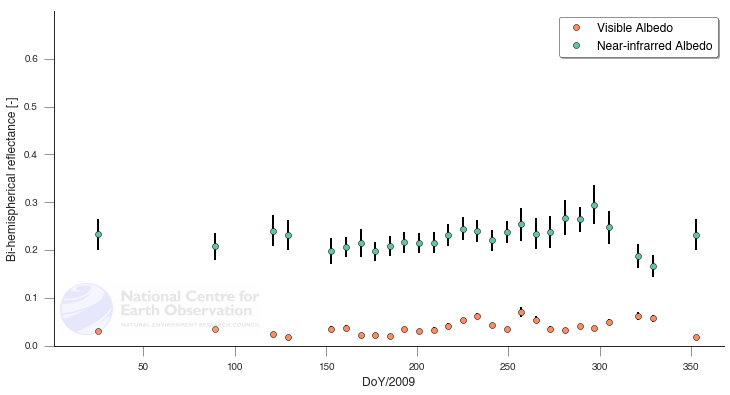

In [3]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from da_gui import *

visualise_albedos()

<div class="question">
<ul>
<li> What are the main processes that are obvious in the data?</li>
<li> How can you relate them to the site in question?</li>
<li> Think of this in terms of radiation fluxes. What is this data telling you?</li>
</ul>
</div>